In [10]:
import os
import numpy as np
import imageio
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from matplotlib import pyplot as plt

from utils.helpers import resize_to_256

In [9]:
crop_aug = iaa.Sometimes(
    0.9,
    iaa.Crop(
        percent=iap.Positive(iap.Normal(0, 0.1)),
        sample_independently=True,
        keep_size=False
    ),
)

# Load random bg from gi

In [8]:
path = './images'
filenames = os.listdir(path)
first_file_path = os.path.join(path, filenames[0])
sample_img = imageio.imread(first_file_path, pilmode="RGB")
sample_arr = np.array(sample_img, dtype=np.uint8)

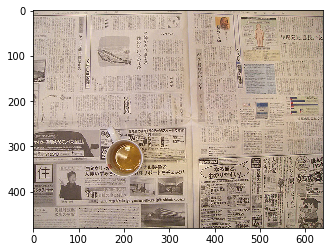

In [11]:
plt.imshow(sample_arr);

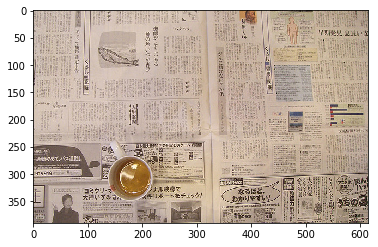

In [19]:
sample_arr_mod = crop_aug.augment_image(sample_arr)
plt.imshow(sample_arr_mod);

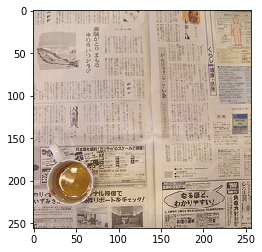

In [21]:
sample_arr_256 = resize_to_256(sample_arr_mod)
plt.imshow(sample_arr_256);

In [22]:
bg = sample_arr_256

# Load original card image

In [23]:
mask_img = imageio.imread('data/train/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)
original_mask = np.array(mask_img, dtype=np.uint8)

card_img = imageio.imread('data/train/original_sample_1000.jpg', pilmode="RGB")
original_card = np.array(card_img, dtype=np.uint8)

In [27]:
def show_mask_and_image(mask_img, card_img):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].set_axis_off()
    axes[0].imshow(mask_img);
    axes[1].set_axis_off()
    axes[1].imshow(card_img);

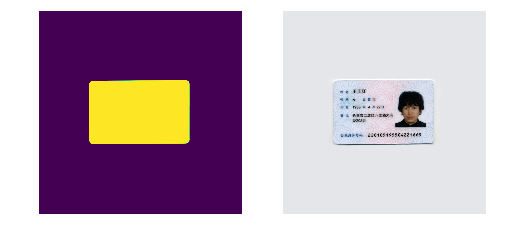

In [28]:
show_mask_and_image(mask_img, card_img)

In [25]:
affine_aug = iaa.Affine(rotate=20, mode='wrap')

rotated_mask = affine_aug.augment_image(original_mask)
rotated_card = affine_aug.augment_image(original_card)

rotated_mask_256 = resize_to_256(rotated_mask)
rotated_card_256 = resize_to_256(rotated_card)

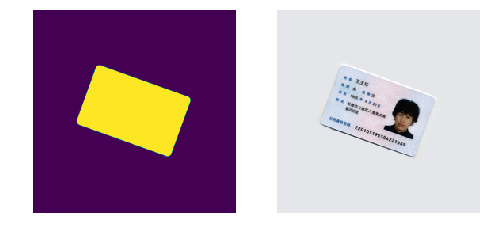

In [29]:
show_mask_and_image(rotated_mask_256, rotated_card_256)

In [30]:
def merge_by_mask(background, foreground, mask):
    w, h, chanells = background.shape
    merg_arr = np.array(background, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if mask[i][j] > 100:
                for c in range(chanells):
                    merg_arr[i][j][c] = foreground[i][j][c]
    return merg_arr

In [31]:
test_img = merge_by_mask(bg, rotated_card_256, rotated_mask_256)

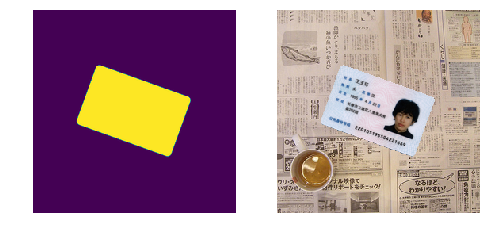

In [32]:
show_mask_and_image(rotated_mask_256, test_img)

# Predict

In [33]:
from utils.unet import get_compiled_model
from utils.helpers import show_predict_mask_above_image

Using TensorFlow backend.


In [34]:
h_size = 256
w_size = 256
start_neurons = 4

In [35]:
model = get_compiled_model(h_size, w_size, start_neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
model.load_weights('./data/weights/n4/w_n4_003.h5')

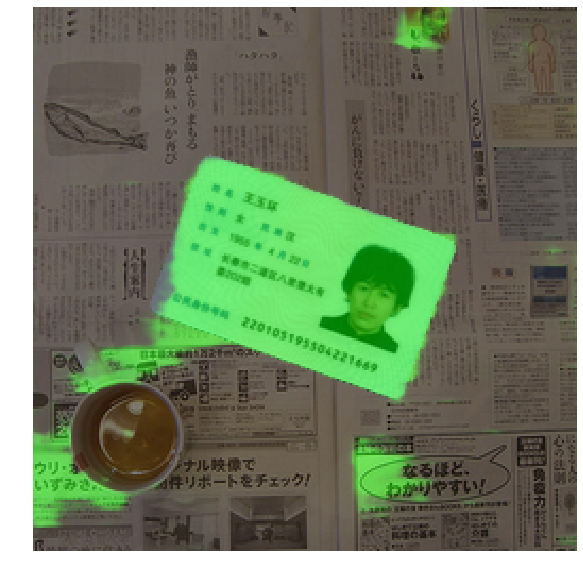

In [37]:
test_arr = np.array(test_img, dtype=np.uint8) / 255.0
show_predict_mask_above_image(test_arr, model, h_size, w_size)

In [59]:
test_x = np.zeros((1, h_size, w_size, 3), dtype='float32')
test_x[0] = test_arr

test_y = model.predict(test_x)
pred_arr = test_y[0]

In [60]:
def get_iou(true_mask: np.ndarray, pred_mask: np.ndarray) -> float:
    t = true_mask/np.max(true_mask)
    p = pred_mask.reshape(true_mask.shape)/np.max(pred_mask)
    true = np.sum(t)
    pred = np.sum(p)
    intersection = np.sum(t * p)
    union = true + pred - intersection
    return intersection / union

In [61]:
get_iou(rotated_mask_256, pred_arr)

0.7313824881523612

# Let's make pipeline

In [62]:
def load_model(h_size, w_size, start_neurons, weights_path):
    model = get_compiled_model(h_size, w_size, start_neurons)
    model.load_weights(weights_path)
    return model

In [63]:
h_size = 256
w_size = 256
start_neurons = 4
weights_path = './data/weights/n4/w_n4_003.h5'

In [64]:
model = load_model(h_size, w_size, start_neurons, weights_path)

In [86]:
def get_predict_mask(img: np.ndarray) -> np.ndarray:
    # prepare
    test_x = np.array(img, dtype='float32') / 255.0
    test_x = np.expand_dims(test_x, axis=0)
    
    # predict
    test_y = model.predict(test_x)
    return test_y.reshape(img.shape[0], img.shape[1], 1)

In [87]:
predict = get_predict_mask(test_img)

In [88]:
get_iou(rotated_mask_256, predict)

0.7313824881523612

In [91]:
import keras

In [92]:
def get_precision(model: keras.engine.training.Model, img: np.ndarray) -> float:
    predict = get_predict_mask(img)
    iou = get_iou(rotated_mask_256, predict)
    return iou

In [93]:
get_precision(model, test_img)

0.7313824881523612

# Iterate by GI images

In [94]:
def get_bg(path, filename):
    first_file_path = os.path.join(path, filename)
    sample_img = imageio.imread(first_file_path, pilmode="RGB")
    sample_arr = np.array(sample_img, dtype=np.uint8)
    sample_arr_mod = sample_arr  # crop_aug.augment_image(sample_arr)
    sample_arr_256 = resize_to_256(sample_arr_mod)
    return sample_arr_256

In [96]:
path = './images'
filenames = os.listdir(path)
stat = {}
for filename in filenames:
    try:
        bg = get_bg(path, filename)
    except:
        continue
    test_img = merge_by_mask(bg, rotated_card_256, rotated_mask_256)
    precision = get_precision(model, test_img)
    stat[filename] = precision

In [97]:
sorted_stat = sorted(stat.items(), key=lambda kv: kv[1])

In [98]:
sorted_stat[:10]

[('4. firstpage-s0021911800044831a.jpg', 0.17574522595881256),
 ('1. fltr-1.jpg', 0.182289506952451),
 ('5. fltr-1.jpg', 0.182289506952451),
 ('5. shutterstock_193652336-1200x799.jpg', 0.2109709216731045),
 ('1. 1102.jpg', 0.2222966328436942),
 ('4. cover_issue_10547_en_us.jpg', 0.2533132428476209),
 ('2. dp2v9tty-1381627354.jpg', 0.25366068515618484),
 ('5. c369e156271c0e36ca51c8bd4da6bd97.jpg', 0.25450800440850874),
 ('3. 14006572571400669023l.jpg', 0.25744314678338565),
 ('1. 14006572571400669023l.jpg', 0.25744314678338565)]

In [99]:
sorted_stat[-10:]

[('4. 237870.jpg', 0.9556271434241667),
 ('4. 1a0cbd22-40f6-42e3-93cf-26cb8f228dcb-1038x576.jpeg', 0.959034703690616),
 ('3. cover_issue_9455_en_us.jpg', 0.9600754529497751),
 ('2. maxresdefault.jpg', 0.9692020444277114),
 ('4. bee-sting-2.jpg', 0.9709276786728668),
 ('2. chinese-sting-3.jpg', 0.9766273447000763),
 ('2. weaver-ants-rip-apart-red-ant.jpg', 0.9783532118698163),
 ('5. 17469937.jpg', 0.9802042410932309),
 ('1. article-2391201-1b449f93000005dc-72_634x387.jpg', 0.9806226190257111),
 ('5. bee_sting_allergy_symptoms_of_anaphylaxis-732x549-thumbnail.jpg',
  0.9819431899792042)]

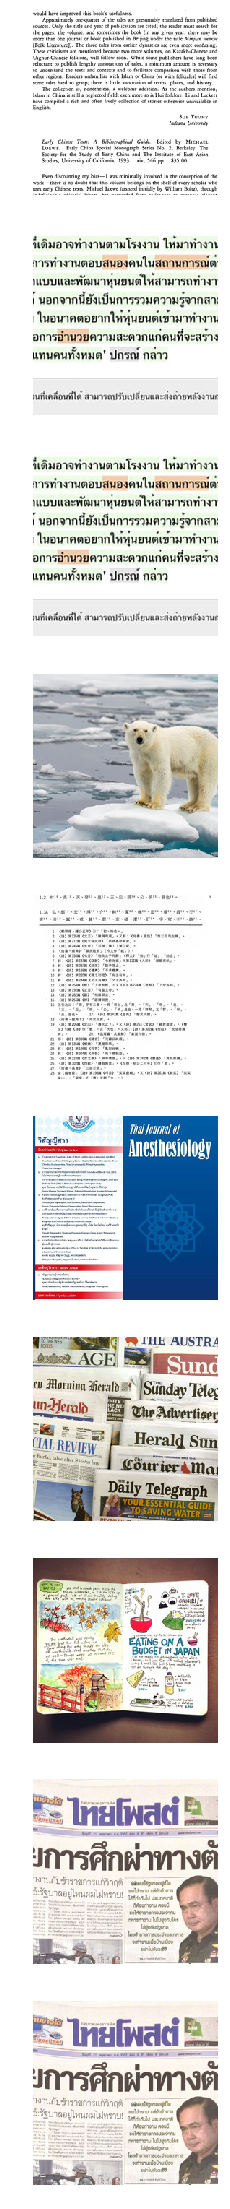

In [102]:
fig, axes = plt.subplots(10, 1, figsize=(4, 40))
i = 0
for filename, p in sorted_stat[:10]:
    bg = get_bg(path, filename)
    axes[i].set_axis_off()
    axes[i].imshow(bg)
    i += 1

In [110]:
# fig, axes = plt.subplots(10, 1, figsize=(4, 40))
# i = 0
res = []
for filename, p in sorted_stat[-10:]:
    print(filename)
    bg = get_bg(path, filename)
    res.append(np.sum(bg))
#     axes[i].set_axis_off()
#     axes[i].imshow(bg)
#     i += 1

In [114]:
sorted_stat

[('4. firstpage-s0021911800044831a.jpg', 0.17574522595881256),
 ('1. fltr-1.jpg', 0.182289506952451),
 ('5. fltr-1.jpg', 0.182289506952451),
 ('5. shutterstock_193652336-1200x799.jpg', 0.2109709216731045),
 ('1. 1102.jpg', 0.2222966328436942),
 ('4. cover_issue_10547_en_us.jpg', 0.2533132428476209),
 ('2. dp2v9tty-1381627354.jpg', 0.25366068515618484),
 ('5. c369e156271c0e36ca51c8bd4da6bd97.jpg', 0.25450800440850874),
 ('3. 14006572571400669023l.jpg', 0.25744314678338565),
 ('1. 14006572571400669023l.jpg', 0.25744314678338565),
 ('4. _103519717_letter1.jpg', 0.26833333200377507),
 ('1. c1_1148912_620x413.jpg', 0.2696261115914339),
 ('5. thenation.jpg', 0.28478251362152635),
 ('4. thenation.jpg', 0.28478251362152635),
 ('2. 121120khaosod.jpg', 0.28801356947994544),
 ('3. 121120khaosod.jpg', 0.28801356947994544),
 ('4. fa79fbc29881431ea6fb265c4375a3af.jpg', 0.2905834858211515),
 ('5. guangzhou-guangdong-province-china-chinese-newspapers-in-city-of-guangzhou-c9badd.jpg',
  0.2950773938260